In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [6]:
lp = pd.read_csv('../Loan_performance.csv')

dtypes      = lp.dtypes
null_counts = lp.isnull().sum()
distinct_obj = lp.select_dtypes(include="object").nunique(dropna=True)

print("Data Shape: ", lp.shape)


print(pd.concat({
    "dtype": dtypes,
    "null_count": null_counts,
    },
    axis = 1
    ))

Data Shape:  (646127, 5)
                    dtype  null_count
analytics_matchkey  int64           0
max_loan_amount     int64           0
late_30_days        int64           0
late_60_days        int64           0
late_90_days        int64           0


In [7]:
lp.groupby(["late_30_days", "late_60_days", "late_90_days"]).count().head()


analytics_matchkey  max_loan_amount
late_30_days late_60_days late_90_days                                     
0            0            0                         567578           567578
1            0            0                          19390            19390
             1            0                           6434             6434
                          1                          52725            52725

In [26]:

lp.groupby("analytics_matchkey").size().sort_values(ascending=False).head()

analytics_matchkey
1346745    1
1777527    1
1777520    1
1777521    1
1777522    1
dtype: int64

### Takeaways

- Im supprised that there is a only a single record per analytics_matchkey. 

/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_93358/4075958572.py:14: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


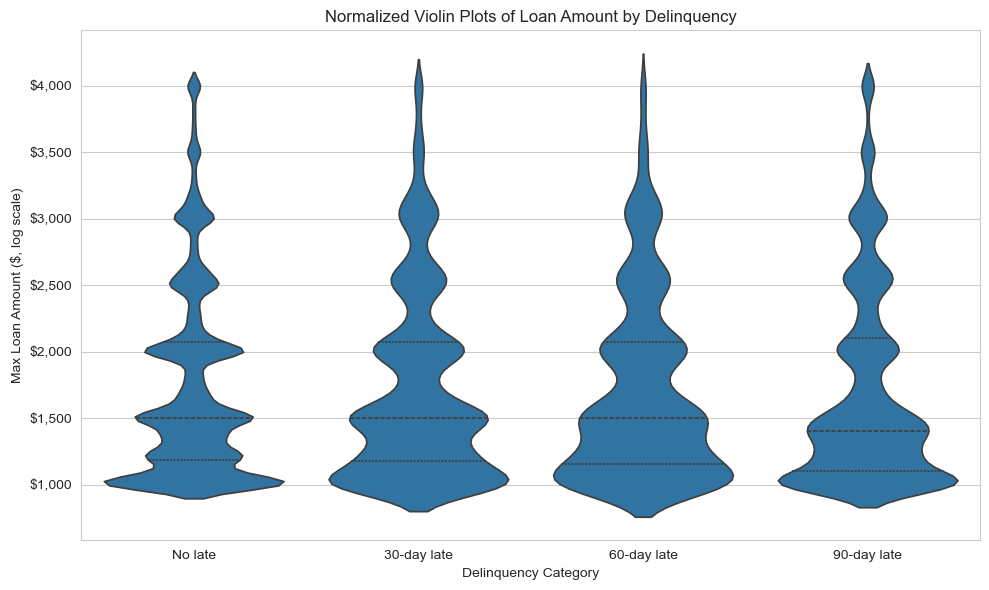

In [33]:
import numpy as np

cond = [
    (lp.late_90_days == 1),
    (lp.late_60_days == 1) & (lp.late_90_days == 0),
    (lp.late_30_days == 1) & (lp.late_60_days == 0),
    (lp.late_30_days == 0)
]
choices = ['90-day late','60-day late','30-day late','No late']
lp['delq_cat'] = np.select(cond, choices)

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=lp,
    x='delq_cat',
    y='max_loan_amount',
    order=['No late','30-day late','60-day late','90-day late'],
    scale='width', 
    inner='quartile'
)


ax = plt.gca()
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
)

plt.xlabel('Delinquency Category')
plt.ylabel('Max Loan Amount ($, log scale)')
plt.title('Normalized Violin Plots of Loan Amount by Delinquency')
plt.tight_layout()
plt.show()


## Loan amounts tend to cluster near even groups so i will group them and see if there is a pattern that way

<Figure size 1200x600 with 0 Axes>

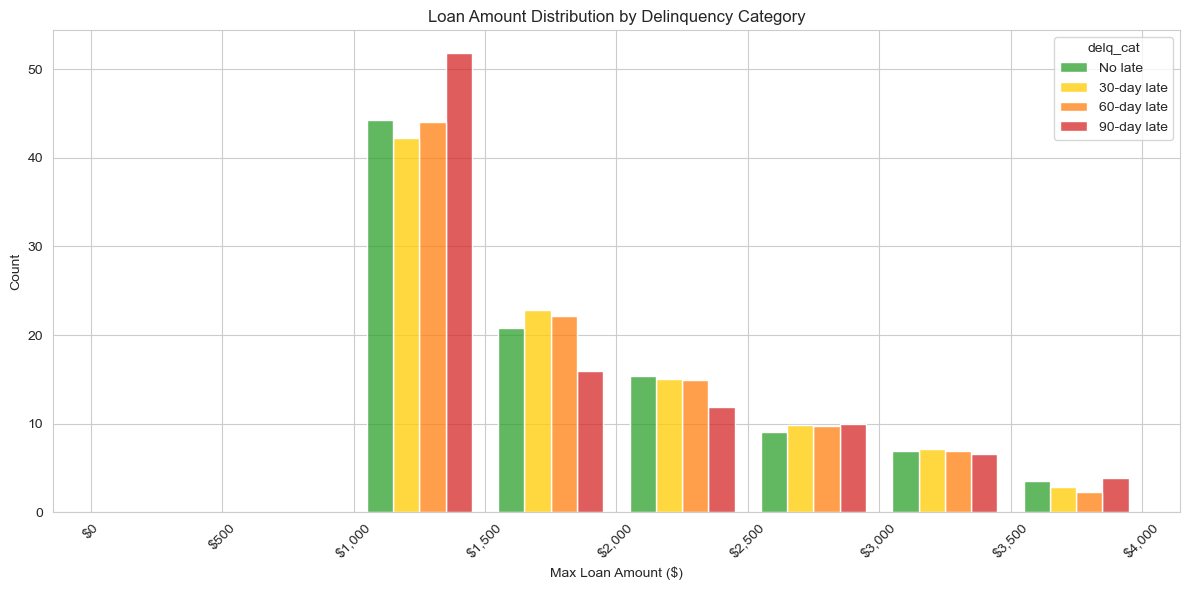

In [ ]:
max_amt = lp['max_loan_amount'].max()
bins = np.arange(0, max_amt + 500, 500)

# 2) Plot with seaborn’s dodge‐style histogram
plt.figure(figsize=(12,6))
palette = {
    'No late':       '#2ca02c',
    '30-day late':   '#ffcc00',
    '60-day late':   '#ff7f0e',
    '90-day late':   '#d62728'
}

plt.figure(figsize=(12,6))
sns.histplot(
    data=lp,
    x='max_loan_amount',
    hue='delq_cat',
    bins=bins,
    multiple='dodge',
    shrink=0.8,
    stat='percent',
    common_norm=False,
    palette=palette,
    edgecolor='w'
)

# 3) Formatting
plt.xlabel('Max Loan Amount ($)')
plt.ylabel('Count')
plt.title('Loan Amount Distribution by Delinquency Category')
plt.xticks(bins, [f'${int(b):,}' for b in bins], rotation=45)
# plt.legend(title='Delinquency', loc='upper right')
plt.tight_layout()
plt.show()

In [52]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


# Are our groups different?
model = ols('max_loan_amount ~ C(delq_cat)', data=lp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA table:")
print(anova_table)

# Anova is signifficant so we want to doi a paired and adjsted test 
tukey = pairwise_tukeyhsd(
    endog=lp['max_loan_amount'],
    groups=lp['delq_cat'],
    alpha=0.05
)
print("\nTukey HSD results:")
print(tukey.summary())


ANOVA table:
                   sum_sq        df          F        PR(>F)
C(delq_cat)  3.517892e+07       3.0  21.954526  3.283413e-14
Residual     3.451059e+11  646123.0        NaN           NaN

Tukey HSD results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
30-day late 60-day late -19.5834 0.2444 -46.5962  7.4294  False
30-day late 90-day late  -19.621 0.0076   -35.39  -3.852   True
30-day late     No late   5.9232 0.6835  -7.7885  19.635  False
60-day late 90-day late  -0.0376    1.0 -24.8318 24.7566  False
60-day late     No late  25.5066 0.0276   1.9672  49.046   True
90-day late     No late  25.5442    0.0  16.9962 34.0923   True
---------------------------------------------------------------


### The differences bewtween Not being late and late in terms of loan amount are signifficant, but the effect size may not be large enough for it to matter